# Rotta EQ Discovery

*Authors: Antony Sikorski*

A simpler notebook for EQ discovery for the Rotta model. We do this with the `PySR` package for symbolic regression, an ML method for finding interpretable symbolic expressions.

In [1]:
#importing libraries
# from pdfs import *
import os
import re

import xarray as xr
import netCDF4 as nc
import h5netcdf

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import pysr
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Functions:

In [2]:
def list_directories_files(path):
    """
    provides all files and directories from the LES simulations (they start with Ug)

    Parameters:
    - path (str): The path to the LES simulation data.

    Returns:
    - directories (list): A list of all directories starting with 'Ug'.
    - files (list): A list of all files starting with 'Ug'.
    """

    # all items in the given path
    items = os.listdir(path)
    
    # find the directories starting with 'Ug'
    directories = [item for item in items if os.path.isdir(os.path.join(path, item)) and item.startswith('Ug')]
    # find the files starting with 'Ug'
    files = [item for item in items if os.path.isfile(os.path.join(path, item)) and item.startswith('Ug')]
    
    return directories, files

In [3]:
def time_average(data, timeavg):
    """
    Averages an array over specified number of time steps. Works for both 1D and higher-dimensional arrays.

    Parameters:
    - data (numpy.ndarray): The input data array. Expected shapes are either (ntime,) or (ntime, nz).
    - timeavg (int): The number of time steps over which to average.

    Returns:
    - numpy.ndarray: The averaged data array.
    """
    ntime = data.shape[0]
    nchunks = ntime // timeavg
    truncated_data = data[:nchunks * timeavg]

    if data.ndim == 1:
        # for 1D arrays, reshape to (nchunks, timeavg)
        reshaped_data = truncated_data.reshape(nchunks, timeavg)
    else:
        # for 2D arrays, old method with reshaping
        nz = data.shape[1]
        reshaped_data = truncated_data.reshape(nchunks, timeavg, nz)

    # compute the mean along the new time axis 
    averaged_data = reshaped_data.mean(axis=1)

    return averaged_data


In [4]:
def make_variables(path, items, time_avg):
    """
    Extracts the variables of interest from the LES simulations and averages them over specified number of time steps.

    Parameters:
    - path (str): The path to the LES simulation data.
    - items (list): A list of files containing the LES simulation data.
    - time_avg (int): The number of time steps over which to average.

    Returns:
    - all variables (numpy.ndarray)
    """

    # Initialize empty lists to accumulate results
    sigma_th = []
    sigma_2 = []
    Theta = []
    wtheta = []
    wwtheta = []
    rdstr = []
    transport = []

    for item in items:
        ds_stat = nc.Dataset(os.path.join(path, item), mode='r')
        
        sigma_th_temp = time_average(ds_stat.groups['thermo']['th_2'][:], time_avg)  # covariance of theta
        sigma_2_temp = time_average(ds_stat.groups['default']['w_2'][:], time_avg)   # covariance of w
        Theta_temp = time_average(ds_stat.groups['thermo']['th'][:], time_avg)       # domain mean theta
        wtheta_temp = time_average(ds_stat.groups['thermo']['th_flux'][:], time_avg) # heat flux
        wwtheta_temp = time_average(ds_stat.groups['budget']['wwtheta'][:], time_avg) # third moment, covariance between wtheta and w
        rdstr_temp = time_average(ds_stat.groups['budget']['bw_rdstr'][:], time_avg) # pressure redistribution term
        transport_temp = time_average(ds_stat.groups['budget']['bw_pres'][:], time_avg) # pressure transport term

        # Append the results to the respective lists
        sigma_th.append(sigma_th_temp)
        sigma_2.append(sigma_2_temp)
        Theta.append(Theta_temp)
        wtheta.append(wtheta_temp)
        wwtheta.append(wwtheta_temp)
        rdstr.append(rdstr_temp)
        transport.append(transport_temp)

    # Concatenate the results along the time axis
    sigma_th = np.concatenate(sigma_th, axis=0)
    sigma_2 = np.concatenate(sigma_2, axis=0)
    Theta = np.concatenate(Theta, axis=0)
    wtheta = np.concatenate(wtheta, axis=0)
    wwtheta = np.concatenate(wwtheta, axis=0)
    rdstr = np.concatenate(rdstr, axis=0)
    transport = np.concatenate(transport, axis=0)

    return sigma_th, sigma_2, Theta, wtheta, wwtheta, rdstr, transport

In [5]:
def reshape_variables(variable):
    reshaped = (variable[:, :-1] + variable[:, 1:]) / 2.0
    return reshaped


def extract_ug_q(filename):
    # Extracting 'ug' and 'q' from the filename
    match = re.search(r'Ug(\d+)Q(\d+)', filename)
    ug = int(match.group(1))
    q = int(match.group(2))

    return ug, q

In [6]:
def make_constants(path, items, time_avg):
    """
    Extracts the constants of interest from the LES simulations and averages them over specified number of time steps.

    Parameters:
    - path (str): The path to the LES simulation data.
    - items (list): A list of files containing the LES simulation data.
    - time_avg (int): The number of time steps over which to average.

    Returns:
    - all constants (numpy.ndarray)
    """
    wtheta_surface = []
    pbl_height = []
    wstar = []
    theta_star = []
    scaling = []
    ustar = []
    grr = 9.8
    T_0 = 300
    beta = grr/T_0
    ug = []
    q = []

    for item in items:
        ds_stat = nc.Dataset(os.path.join(path, item), mode='r')

        wtheta_surface_raw = ds_stat.groups['thermo']['th_flux'][:,0] 
        wtheta_surface_temp = time_average(wtheta_surface_raw, time_avg)

        pbl_height_raw = ds_stat.groups['thermo'].variables['zi'][:] 
        pbl_height_temp = time_average(pbl_height_raw, time_avg)

        wstar_raw = np.power( beta * (wtheta_surface_raw) * pbl_height_raw , 1/3) 
        wstar_temp = time_average(wstar_raw, time_avg)

        theta_star_raw = wtheta_surface_raw / wstar_raw
        theta_star_temp = time_average(theta_star_raw, time_avg)

        scaling_raw = wstar_raw**2 * theta_star_raw / pbl_height_raw
        scaling_temp = time_average(scaling_raw, time_avg)

        ustar_temp = time_average(ds_stat.groups['default'].variables['ustar'][:], time_avg)

        ug_val, q_val = extract_ug_q(item)
        # ug = np.ma.masked_array(np.full(wtheta_surface_temp.shape, ug_val), mask=wtheta_surface_temp.mask)
        # q = np.ma.masked_array(np.full(wtheta_surface_temp.shape, q_val), mask=wtheta_surface_temp.mask)
        ug_repeat = np.full(wtheta_surface_temp.shape, ug_val)
        q_repeat = np.full(wtheta_surface_temp.shape, q_val)

        wtheta_surface.append(wtheta_surface_temp)
        pbl_height.append(pbl_height_temp)
        wstar.append(wstar_temp)
        theta_star.append(theta_star_temp)
        scaling.append(scaling_temp)
        ustar.append(ustar_temp)
        ug.append(ug_repeat)
        q.append(q_repeat)

    wtheta_surface = np.concatenate(wtheta_surface, axis=0)
    pbl_height = np.concatenate(pbl_height, axis=0)
    wstar = np.concatenate(wstar, axis=0)
    theta_star = np.concatenate(theta_star, axis=0)
    scaling = np.concatenate(scaling, axis=0)
    ustar = np.concatenate(ustar, axis=0)
    ug = np.concatenate(ug, axis=0)
    q = np.concatenate(q, axis=0)

    wtheta_surface = wtheta_surface[:,np.newaxis]
    pbl_height = pbl_height[:,np.newaxis]
    wstar = wstar[:,np.newaxis]
    theta_star = theta_star[:,np.newaxis]
    scaling = scaling[:,np.newaxis]
    ustar = ustar[:,np.newaxis]
    ug = ug[:,np.newaxis]
    q = q[:,np.newaxis]

    return wtheta_surface, pbl_height, wstar, theta_star, scaling, ustar, grr, T_0, beta, ug, q

### Data Processing

This lists all of our files. **If someone else is using this notebook, all that needs to be changed to reproduce results is the path.** 

In [7]:
path = 'C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim_2/'


directories, files = list_directories_files(path)
print("Directories starting with 'Ug':", directories)
print("Files starting with 'Ug':", files)

Directories starting with 'Ug': []
Files starting with 'Ug': ['Ug16Q000_IV.nc', 'Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc', 'Ug16Q006_IV.nc', 'Ug16Q010_IV.nc', 'Ug1Q01_II.nc', 'Ug2Q010_I.nc', 'Ug2Q010_IV.nc', 'Ug2Q01_III.nc', 'Ug2Q024_I.nc', 'Ug8Q003_II.nc', 'Ug8Q003_III.nc', 'Ug8Q003_IV.nc', 'Ug8Q006_IV.nc']


In [8]:
items = files

Let's see which ones have the budget category (we need variables from it): 

In [9]:
for item in items:
    ds_stat = nc.Dataset( os.path.join(path, item), mode='r')
    if 'budget' in ds_stat.groups:
        print ("budget is in", item)
    else:
        print ("budget is not in", item)

budget is not in Ug16Q000_IV.nc
budget is in Ug16Q001_IV.nc
budget is in Ug16Q003_IV.nc
budget is in Ug16Q006_I.nc
budget is in Ug16Q006_IV.nc
budget is in Ug16Q010_IV.nc
budget is in Ug1Q01_II.nc
budget is in Ug2Q010_I.nc
budget is in Ug2Q010_IV.nc
budget is in Ug2Q01_III.nc
budget is in Ug2Q024_I.nc
budget is in Ug8Q003_II.nc
budget is in Ug8Q003_III.nc
budget is in Ug8Q003_IV.nc
budget is in Ug8Q006_IV.nc


It appears that we can use all files except the very first (`000`) file. Going to print out all of the viable files so we can see dimension sizes and groups: 

In [10]:
for item in items[1:]:
    print(item)
    df = nc.Dataset(path + '/' + item, mode='r')
    print(df)

Ug16Q001_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q003_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_I.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(90)
    variables(dimensions): float64 time(time), float64 z(z), f

This should create selected files for a given list of `items`. In my case, my `selected_files` constitutes a group of similar (I think) simulations that I can append together for the sake of having more data. For now (for ease of use) I want them all to have the same `z` and `zh` dimensions.

In [11]:
target_z_dim = 384

selected_files = []

for item in items[1:]:
        df = nc.Dataset(os.path.join(path, item), mode='r')
        if df.dimensions['z'].size == target_z_dim:
            selected_files.append(item)
        df.close()

print(len(selected_files))
print(selected_files)

11
['Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_IV.nc', 'Ug16Q010_IV.nc', 'Ug1Q01_II.nc', 'Ug2Q010_IV.nc', 'Ug2Q01_III.nc', 'Ug8Q003_II.nc', 'Ug8Q003_III.nc', 'Ug8Q003_IV.nc', 'Ug8Q006_IV.nc']


Let's take a look at all of the variables inside an example file: 

In [12]:
example_df = nc.Dataset(os.path.join(path, selected_files[1]), mode='r')

for group_name, group in example_df.groups.items():
    print(f"Group: {group_name}")
    for var_name, var in group.variables.items():
        long_name = var.getncattr('long_name') if 'long_name' in var.ncattrs() else 'No long_name attribute'
        print(f"  Variable: {var_name}, Long Name: {long_name}")

Group: default
  Variable: iter, Long Name: Iteration number
  Variable: area, Long Name: Fractional area contained in mask
  Variable: areah, Long Name: Fractional area contained in mask
  Variable: eft, Long Name: eft
  Variable: eft_3, Long Name: Moment 3 of the eft
  Variable: eft_4, Long Name: Moment 4 of the eft
  Variable: eft_diff, Long Name: Diffusive flux of the eft
  Variable: eft_w, Long Name: Turbulent flux of the eft
  Variable: eft_grad, Long Name: Gradient of the eft
  Variable: eft_2, Long Name: Moment 2 of the eft
  Variable: eft_path, Long Name: eft path
  Variable: eft_flux, Long Name: Total flux of the eft
  Variable: sft, Long Name: sft
  Variable: sft_3, Long Name: Moment 3 of the sft
  Variable: sft_4, Long Name: Moment 4 of the sft
  Variable: sft_diff, Long Name: Diffusive flux of the sft
  Variable: sft_w, Long Name: Turbulent flux of the sft
  Variable: sft_grad, Long Name: Gradient of the sft
  Variable: sft_2, Long Name: Moment 2 of the sft
  Variable: sft

In [13]:
# wtheta_surface_raw = example_df.groups['thermo']['th_flux'][:,0] 

# test = time_average(wtheta_surface_raw, 15)

# print(test.shape)

# ug = 4

# time_average(wtheta_surface_raw,15)

# ug = np.ma.masked_array(np.full(test.shape, ug), mask=test.mask)
# # q = np.ma.masked_array(np.full(wstar_temp.shape, q_val), mask=wstar_temp.mask)

# ug

# ug.shape

### Making Variables and Constants

We start off with the necessary variables. First we must decide on a time averaging parameter. We will use 15 minutes: 

In [14]:
#choosing a time_avg parameter: 
time_avg = 15

In [15]:
sigma_th, sigma_2, Theta, wtheta, wwtheta, rdstr, transport = make_variables(path, selected_files, time_avg)

z = ds_stat.variables['z'][:]
zh = ds_stat.variables['zh'][:]
t = ds_stat.variables['time'][:]
dTheta_dz = np.gradient(Theta, z, axis = 1)
dwwtheta_dz = np.gradient(wwtheta, zh, axis = 1)

Sanity (order of magnitude) checks: 

In [16]:
print("dTheta_dz", dTheta_dz.shape, np.mean(dTheta_dz), np.std(dTheta_dz))
print("sigma_th", sigma_th.shape, np.mean(sigma_th), np.std(sigma_th))
print("sigma_2", sigma_2.shape, np.mean(sigma_2), np.std(sigma_2))
print("Theta", Theta.shape, np.mean(Theta), np.std(Theta))
print("wtheta", wtheta.shape, np.mean(wtheta), np.std(wtheta))
print("wwtheta", wwtheta.shape, np.mean(wwtheta), np.std(wwtheta))
print("dwwtheta_dz", dwwtheta_dz.shape, np.mean(dwwtheta_dz), np.std(dwwtheta_dz))
print("rdtsr", rdstr.shape, np.mean(rdstr), np.std(rdstr))
print("transport", transport.shape, np.mean(transport), np.std(transport))

dTheta_dz (82, 384) 0.003963647167860588 0.00465853542139092
sigma_th (82, 384) 0.011884039967426343 0.01781884043464204
sigma_2 (82, 385) 0.2143194520546861 0.2868845719924503
Theta (82, 384) 303.9102511671008 3.6245027161767904
wtheta (82, 385) 0.008187199174384964 0.021235457033364467
wwtheta (82, 385) 0.008443124 0.019204466
dwwtheta_dz (82, 385) 7.007907371582168e-08 0.0001217516532677598
rdtsr (82, 385) -6.665098906347553e-06 2.3542480113465666e-05
transport (82, 385) -1.1689012605362026e-06 2.196535488745957e-05


In [17]:
print(wwtheta[1,0:3])
print((wwtheta[1,0]+wwtheta[1,1])/2, (wwtheta[1,1]+wwtheta[1,2])/2)

[ 0.0000000e+00 -3.1880256e-05 -1.0963364e-04]
-1.594012792338617e-05 -7.075694884406403e-05


Variables that have a second dimension of 385 are calculated at zh values of 0, 6, 12, and so on. Variables with 384 are staggered and calculated in between there, at values of 3, 9, 15, and so on. We reshape the 385's to be 384's by taking the average of each consecutive pair. 

We test if this works above and below with old and new values of `wwtheta` (just a sanity check)

In [18]:
sigma_2 = reshape_variables(sigma_2)
wtheta = reshape_variables(wtheta)
wwtheta = reshape_variables(wwtheta)
dwwtheta_dz = reshape_variables(dwwtheta_dz)
rdstr = reshape_variables(rdstr)
transport = reshape_variables(transport)

In [19]:
print("dTheta_dz", dTheta_dz.shape, np.mean(dTheta_dz), np.std(dTheta_dz))
print("sigma_th", sigma_th.shape, np.mean(sigma_th), np.std(sigma_th))
print("sigma_2", sigma_2.shape, np.mean(sigma_2), np.std(sigma_2))
print("Theta", Theta.shape, np.mean(Theta), np.std(Theta))
print("wtheta", wtheta.shape, np.mean(wtheta), np.std(wtheta))
print("wwtheta", wwtheta.shape, np.mean(wwtheta), np.std(wwtheta))
print("dwwtheta_dz", dwwtheta_dz.shape, np.mean(dwwtheta_dz), np.std(dwwtheta_dz))
print(wwtheta[1,0:2])

dTheta_dz (82, 384) 0.003963647167860588 0.00465853542139092
sigma_th (82, 384) 0.011884039967426343 0.01781884043464204
sigma_2 (82, 384) 0.2148775756277452 0.28702581891303003
Theta (82, 384) 303.9102511671008 3.6245027161767904
wtheta (82, 384) 0.008134205981178014 0.021152086231226993
wwtheta (82, 384) 0.008465109801873929 0.019221094530878103
dwwtheta_dz (82, 384) -6.146483502835338e-14 0.00012119911338346663
[-1.594012792338617e-05 -7.075694884406403e-05]


We plot all variables just to make sure they look correct: 

Text(0.5, 1.0, '(dwwtheta_dz)')

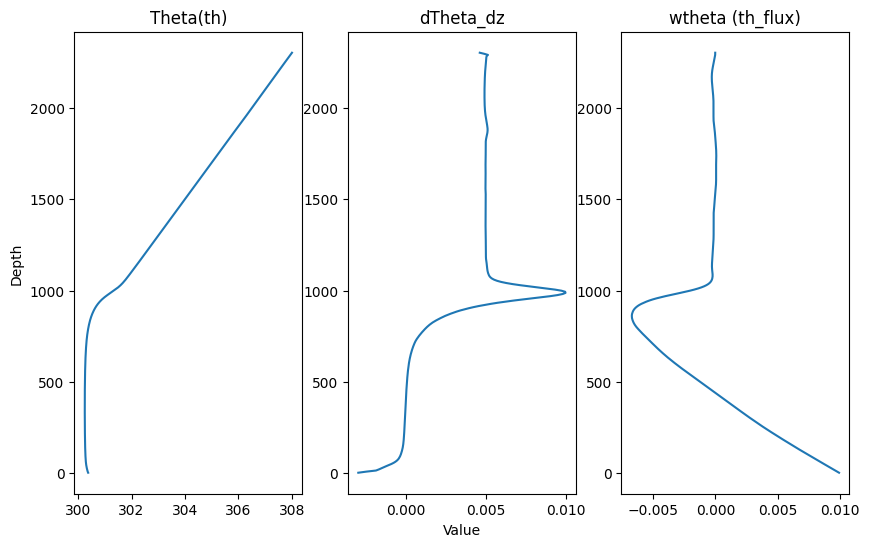

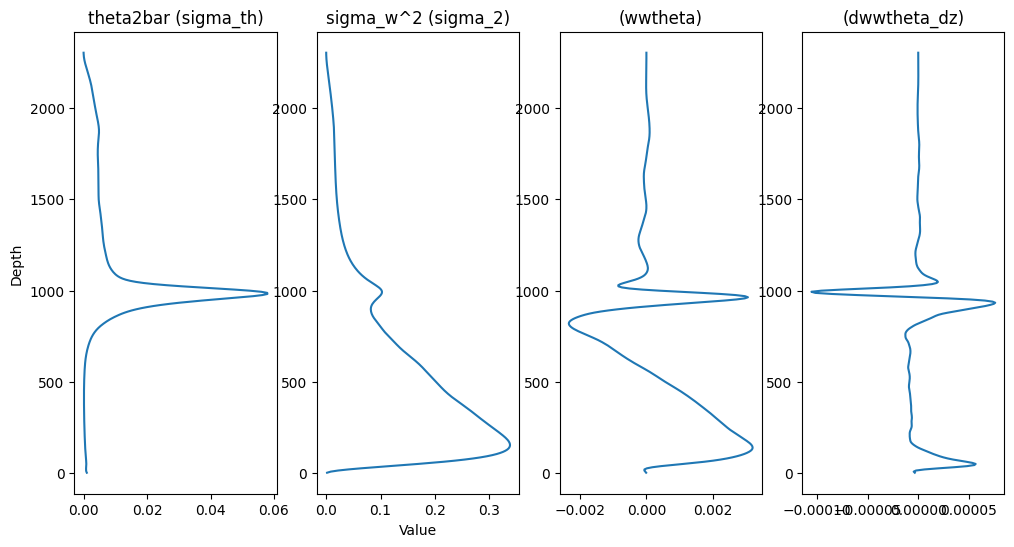

In [20]:
timeStep = 6

plt.figure(figsize = (10, 6))

# Plot potentialTemp
plt.subplot(1, 3, 1)
#plt.plot(Theta[timeStep], np.arange(0, len(Theta[timeStep,:])))
plt.plot(Theta[timeStep], z)
plt.title('Theta(th)')
# plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 3, 2)
# plt.plot(dTheta_dz[timeStep], np.arange(0, len(dTheta_dz[timeStep,:])))
plt.plot(dTheta_dz[timeStep], z)
plt.title('dTheta_dz')
plt.xlabel('Value')
# plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 3, 3)
# plt.plot(wtheta[timeStep], np.arange(0, len(wtheta[timeStep,:])))
plt.plot(wtheta[timeStep], z)
plt.title('wtheta (th_flux)')
# plt.xlabel('Value')
# plt.ylabel('Depth')


plt.figure(figsize = (12, 6))

# Plot potentialTemp
plt.subplot(1, 4, 1)
# plt.plot(sigma_th[timeStep], np.arange(0, len(sigma_th[timeStep,:])))
plt.plot(sigma_th[timeStep], z)
plt.title('theta2bar (sigma_th)')
# plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 4, 2)
# plt.plot(sigma_2[timeStep], np.arange(0, len(sigma_2[timeStep,:])))
plt.plot(sigma_2[timeStep], z)
plt.title('sigma_w^2 (sigma_2)')
plt.xlabel('Value')
# plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 4, 3)
# plt.plot(wwtheta[timeStep], np.arange(0, len(wwtheta[timeStep,:])))
plt.plot(wwtheta[timeStep], z)
plt.title('(wwtheta)')
# plt.xlabel('Value')
# plt.ylabel('Depth')

plt.subplot(1, 4, 4)
# plt.plot(dwwtheta_dz[timeStep], np.arange(0, len(dwwtheta_dz[timeStep,:])))
plt.plot(dwwtheta_dz[timeStep], z)
plt.title('(dwwtheta_dz)')
# plt.xlabel('Value')
# plt.ylabel('Depth')

Now let's make our constants, and sanity check them: 

In [21]:
wtheta_surface, pbl_height, wstar, theta_star, scaling, ustar, grr, T_0, beta, ug, q = make_constants(path, selected_files, time_avg)

In [22]:
print("wtheta_surface", wtheta_surface.shape, np.mean(wtheta_surface), np.std(wtheta_surface))
print("pbl_height", pbl_height.shape, np.mean(pbl_height), np.std(pbl_height))
print("wstar", wstar.shape, np.mean(wstar), np.std(wstar))
print("theta_star", theta_star.shape, np.mean(theta_star), np.std(theta_star))
print("scaling", scaling.shape, np.mean(scaling), np.std(scaling))
print("ustar", ustar.shape, np.mean(ustar), np.std(ustar))
print("grr", grr)
print("T_0", T_0)
print("beta", beta)
print("ug", ug.shape, np.mean(ug), np.std(ug))
print("q", q.shape, np.mean(q), np.std(q))

wtheta_surface (82, 1) 0.05707317073170729 0.03365853658536582
pbl_height (82, 1) 1021.0731707317074 97.1732599582934
wstar (82, 1) 1.1874402247535119 0.2901687297287799
theta_star (82, 1) 0.0438071831979399 0.01769722969945113
scaling (82, 1) 7.292094821455066e-05 5.185090852420291e-05
ustar (82, 1) 0.4162597045374181 0.1812825546672867
grr 9.8
T_0 300
beta 0.03266666666666667
ug (82, 1) 9.024390243902438 5.633037584915935
q (82, 1) 3.951219512195122 2.9955350473842035


## Computing P

We want to compute the $P$ term. 

In the paper, Equation (11) for the heat flux budget in the convective boundary layer is: 

$$
\frac{\partial \overline{w \theta}}{\partial t}=0=\underbrace{-\sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}}_M \underbrace{-\frac{\mathrm{d} \overline{w w \theta}}{\mathrm{d} z}}_T \underbrace{-\frac{1}{\rho_0} \theta \frac{\mathrm{d} p}{\mathrm{~d} z}}_P \underbrace{+\beta \overline{\theta^2}}_B
$$

Production terms: Mean gradient production ($M$), and bouyancy production ($B$). Destruction terms: turbulent flux transport ($T$) and the the pressure gradient–potential temperature covariance ($P$). Here, **P can be computed as a residual**. 

$P$ acts as a destruction/sink term for the heat flux $\overline{w \theta}$. Equation (12) provides a parametrization for $P$ as: 

$$
P=-\frac{1}{\rho_0} \overline{\theta \frac{\mathrm{d} p}{\mathrm{~d} z}}=-C_1 \frac{\overline{w \theta}}{\tau_1} - C_2 \beta \overline{\theta^2} + C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}
$$

The first term $-C_1 \frac{\overline{w \theta}}{\tau_1}$ is the "slow" term. It is Rotta's return to isotropy part. Is inversely proportional to time scale $\tau_1$. I think it may also be called the "turbulence-turbulence" interaction. The last two terms are the "rapid" part, with $C_2 \beta \overline{\theta^2}$ being the bouyancy term, and $C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}$ being the shear-turbulence term. 


___

**Goal:**

We compute $P$ as a residual, and then see if we can reconstruct it using the variables from the parametrization ($\overline{w \theta}, \overline{\theta^2}, \sigma_w^2, \frac{\mathrm{d} \Theta}{\mathrm{d} z}$).

If the residual looks different from the direct compute, this means the constants ($C_1, C_2, C_3$) probably need some modification. We may add in other variables such as Wind `ug`, Surface heating `q`, `wstar`, and `ustar` along with others later. 

Computing `P` as residual using Eq 11: 

In [23]:
#computing as residual 
M = (- sigma_2 * dTheta_dz)
T = - dwwtheta_dz
B = (beta * sigma_th)

P = - M - T - B
print(P.shape)
print(f"{np.mean(B):.7f}, {np.std(B):.7f}")
print(f"{np.mean(M):.7f}, {np.std(M):.7f}")
print(f"{np.mean(T):.7f}, {np.std(T):.7f}")
print(f"{np.mean(P):.7f}, {np.std(P):.7f}")
max(P[6])/min(P[6])

(82, 384)
0.0003882, 0.0005821
-0.0001232, 0.0003159
0.0000000, 0.0001212
-0.0002650, 0.0003853


-0.013478176706221048

Also computing `P` directly using Eq 12. 

In [24]:
tau1 = 600 #unsure about this one at the moment, it is in seconds so this is ten minutes. maybe this is reasonable. 
C1 = 3
C2 = 5/12
C3 = 2/5
P_direct = - (C1 * wtheta/tau1) - (C2 * beta * sigma_th) + (C3 * sigma_2 * dTheta_dz)

Let's see how the two compare: 

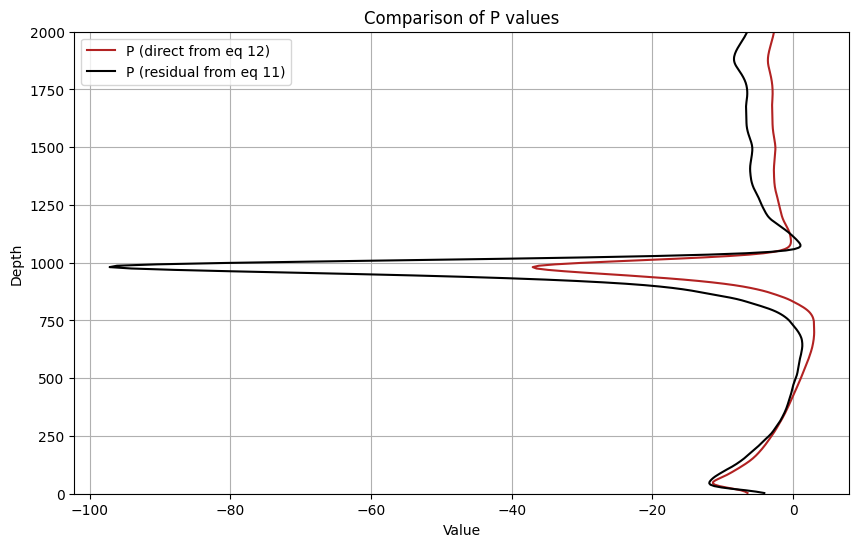

In [25]:
timeStep = 6

plt.figure(figsize=(10, 6))

# Plot P_direct
plt.plot(P_direct[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z, label='P (direct from eq 12)', color = "firebrick")

# Plot P residual
plt.plot(P[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z, label='P (residual from eq 11)', color = "black")

plt.ylim(0, 2000)
plt.title('Comparison of P values')
plt.xlabel('Value')
plt.ylabel('Depth')
plt.legend()
plt.grid(True)

plt.show()

**Note:** Changing the C's can get the directly computed P to look much more like the residual P. If we assume the residual is correct, this means these coefficients could use some work! C2 and C3 seem to have the most effect, with C1 not doing much except changing the shape of the down in the lower ABL. C2 and C3 can really get it to jump out at the inversion layer like the residual. 

A more detailed plot: 

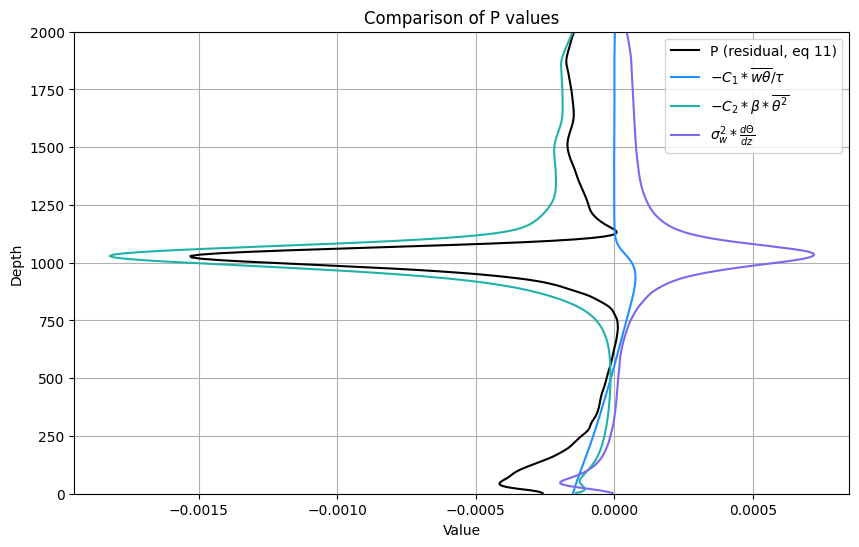

In [26]:
timeStep = 10

plt.figure(figsize=(10, 6))

plt.plot(P[timeStep], z, label = 'P (residual, eq 11)', color = "black")
plt.plot(-0.004997506 * wtheta[timeStep], z, label = r'$- C_1 * \overline{w\theta} / \tau$', color = "dodgerblue")
plt.plot(-0.019068547 * sigma_th[timeStep], z, label = r'$- C_2 * \beta * \overline{\theta^2}$', color = "lightseagreen")
plt.plot(sigma_2[timeStep] * dTheta_dz[timeStep] * 2/5, z, label = r'$\sigma_w^2 * \frac{d\Theta}{dz}$', color = "mediumslateblue")

plt.ylim(0, 2000)
plt.title('Comparison of P values')
plt.xlabel('Value')
plt.ylabel('Depth')
plt.legend()
plt.grid(True)

plt.show()

### Equation Discovery

Let's begin setting up a model to compute `P` from those variables. We will use all moments in time, almost all of our simulations, and most of the ABL vertically. Smaller experiments were tried in our earlier notebook `Steps_to_EQ-Rotta_Sikorski.ipynb` and did not produce nearly as good of results. 

In [27]:
indices = np.s_[:, 0:200]

y = P[indices].ravel()

x0 = wtheta[indices].ravel()
x1 = sigma_th[indices].ravel()
x2 = sigma_2[indices].ravel()
x3 = dTheta_dz[indices].ravel()
X = np.column_stack([x0, x1, x2, x3])

df_X = pd.DataFrame(X, columns=['wtheta', 'sigma_th', 'sigma_2', 'dTheta_dz'])
df_y = pd.DataFrame(y, columns=['P'])
print(df_X.shape, df_y.shape)

(16400, 4) (16400, 1)


In [28]:
model = PySRRegressor(
    niterations=2500,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        "square",
        "cube",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    batching = True,
    batch_size = 250,
    complexity_of_operators={"*": 1, "+": 1, "-": 1,
                             "exp": 3, "sin": 3, "cos": 3, 
                             "inv": 3, "square": 3, "cube": 3},
    # ^ Custom complexity of particular operators
    maxdepth=5,
    # ^ But, avoid deep nesting.
)

In [29]:
model.fit(df_X,df_y)

Compiling Julia backend...


c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.760e+03
Head worker occupation: 16.9%
Progress: 126 / 37500 total iterations (0.336%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.461e-01  1.594e+01  y = sigma_2
3           5.077e-08  7.469e+00  y = sigma_th * -0.021125
5           4.246e-08  8.938e-02  y = (sigma_th - dTheta_dz) * -0.019431
7           2.574e-08  2.502e-01  y = (sigma_th * -0.031612) + (dTheta_dz * sigma_2)
15          1.993e-08  3.199e-02  y = (((sigma_2 * sigma_th) + sigma_th) * -0.17542) * ((wtheta ...
                                  + (0.31886 * dTheta_dz)) + 0.10071)
19          1.452e-08  7.910e-02  y = (((sigma_th + sigma_th) + wtheta) * (square(-0.42366) + si...
                                  gma_th)) / inv(-0.23285 * 0.16554)
---------------------------------------------------------------------------------------------------
Press 'q' and then 

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                     -0.00033383848   
	1        0.801699                            sigma_th * -0.020900732   
	2        0.210388                (dTheta_dz - sigma_th) * 0.02335675   
	3        0.382382  ((wtheta + 0.093727976) * sigma_th) * -0.20843425   
	4        0.045242  ((wtheta + (sigma_th / 0.3417825)) - 0.0075600...   
	5  >>>>  0.126266  -0.006983325 * (((wtheta + sigma_th) * (1.7139...   
	6        0.112735  ((0.61661136 * dTheta_dz) * sigma_2) + (sigma_...   
	7        0.017323  ((dTheta_dz * 0.61661136) * sigma_2) + ((cube(...   
	8        0.020767  ((dTheta_dz * (0.61661136 - wtheta)) * sigma_2...   
	
	           loss  complexity  
	0  2.521359e-07           1  
	1  5.073269e-08           3  
	2  3.330792e-08           5  
	3  1.550296e-08           7  
	4  1.416179e-08           9  
	5  1.100131e-08          11  
	6  8.780595e-09          13  
	7  8.335925e-09          16  
	8  7.996793e-09          18  
]

In [35]:
equations = model.equations_
print(equations.shape)
display(equations)
print("Final Equation: ")
display(equations.iloc[-1, 4])
print(equations.iloc[-1,3])

(9, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,2.521359e-07,0.000000,-0.00033383848,-0.000333838480000000,PySRFunction(X=>-0.000333838480000000)
1,3,5.073269e-08,0.801699,sigma_th * -0.020900732,-0.020900732*sigma_th,PySRFunction(X=>-0.020900732*sigma_th)
2,5,3.330792e-08,0.210388,(dTheta_dz - sigma_th) * 0.02335675,0.02335675*dTheta_dz - 0.02335675*sigma_th,PySRFunction(X=>0.02335675*dTheta_dz - 0.02335...
3,7,1.550296e-08,0.382382,((wtheta + 0.093727976) * sigma_th) * -0.20843425,-0.20843425*sigma_th*(wtheta + 0.093727976),PySRFunction(X=>-0.20843425*sigma_th*(wtheta +...
4,9,1.416179e-08,0.045242,((wtheta + (sigma_th / 0.3417825)) - 0.0075600...,-0.0204320730289*sigma_th - 0.006983325*wtheta...,PySRFunction(X=>-0.0204320730289*sigma_th - 0....
5,11,1.100131e-08,0.126266,-0.006983325 * (((wtheta + sigma_th) * (1.7139...,-0.006983325*sigma_th - 0.006983325*(1.7139474...,PySRFunction(X=>-0.006983325*sigma_th - 0.0069...
6,13,8.780595e-09,0.112735,((0.61661136 * dTheta_dz) * sigma_2) + (sigma_...,0.61661136*dTheta_dz*sigma_2 - 0.0261128660311...,PySRFunction(X=>0.61661136*dTheta_dz*sigma_2 -...
7,16,8.335925e-09,0.017323,((dTheta_dz * 0.61661136) * sigma_2) + ((cube(...,0.61661136*dTheta_dz*sigma_2 - 0.0269567038678...,PySRFunction(X=>0.61661136*dTheta_dz*sigma_2 -...
8,18,7.996793e-09,0.020767,((dTheta_dz * (0.61661136 - wtheta)) * sigma_2...,dTheta_dz*sigma_2*(0.61661136 - wtheta) - 0.02...,PySRFunction(X=>dTheta_dz*sigma_2*(0.61661136 ...


Final Equation: 


dTheta_dz*sigma_2*(0.61661136 - wtheta) - 0.027153382143911*sigma_th

((dTheta_dz * (0.61661136 - wtheta)) * sigma_2) + ((cube(-1.1232659) * (-0.06063635 * sigma_th)) * -0.31596804)


Let's look at some past discovered eq's: 

In [38]:
discovered_eq1 = (-0.004997506 * wtheta) - (sigma_th * 0.019068547)
discovered_eq2 = (((sigma_th * wtheta) + (sigma_2 * 0.4073766)) * dTheta_dz) - (0.02337299 * (sigma_th + (0.13268535 * wtheta)))
# discovered_eq3 = (dTheta_dz * sigma_2 * ((0.61661136 - wtheta))) - 0.0271534 * sigma_th

In [32]:
#EQUATION 1
# discovered value in front of sigma_th is -0.019068547 or - 0.02337299
print(- C2*beta)
#close enough\

#discovered value in front of wtheta is -0.004997506
print(- C1/tau1)
# also close enough


#EQUATION 2
#as far as eq2 goes, it appears that the added multiplication is not of an important size
print(np.mean(abs(sigma_th[timeStep] * wtheta[timeStep] * dTheta_dz[timeStep])))
print(np.mean(abs(dTheta_dz[timeStep] * sigma_2[timeStep] * 0.4)))

8/12 * beta # so it appears C2 should be larger, maybe 8/12 instead of 5/12

print(C1)
print(3/tau1)
print(2/tau1)
print(3/1000)
0.02337299 * 0.13268535

# so either tau1 needs to be 1000 or C1 needs to be 2 instead of 3

-0.013611111111111114
-0.005
3.745525378677423e-07
9.987698048903196e-05
3
0.005
0.0033333333333333335
0.003


0.0031012533586965

Plotting to answer some questions (below):

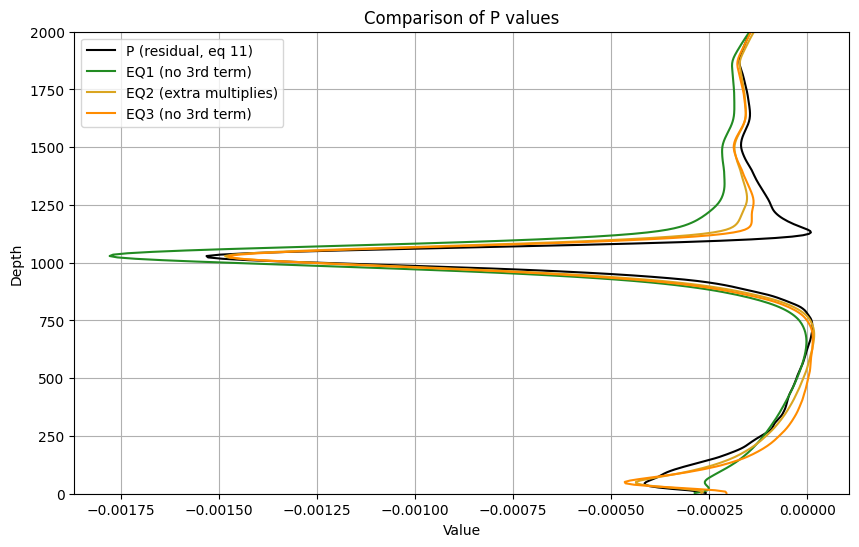

In [39]:
timeStep = 10

plt.figure(figsize=(10, 6))

plt.plot(P[timeStep], z, label = 'P (residual, eq 11)', color = "black")

plt.plot(discovered_eq1[timeStep], z, label = 'EQ1 (no 3rd term)', color = 'forestgreen')
plt.plot(discovered_eq2[timeStep], z, label = 'EQ2 (extra multiplies)', color = 'goldenrod')
# plt.plot(discovered_eq3[timeStep], z, label = 'EQ3 (no 3rd term)', color = 'darkorange')

# plt.plot(P_direct[timeStep], z, label = 'P (direct, eq12)')

plt.ylim(0, 2000)
plt.title('Comparison of P values')
plt.xlabel('Value')
plt.ylabel('Depth')
plt.legend()
plt.grid(True)

plt.show()

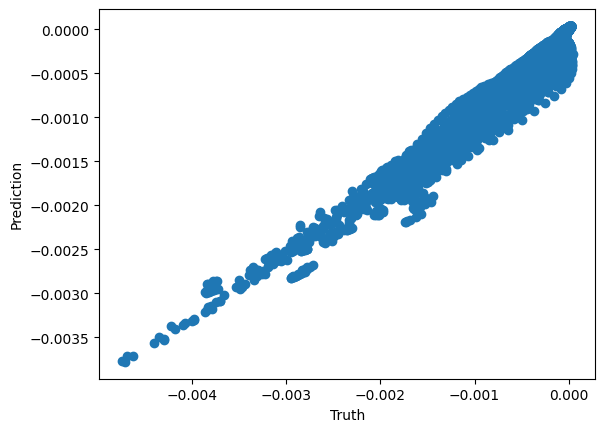

In [34]:
plt.scatter(y, model.predict(X))
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()